# Empirical Cross Covariance

Note that the analysis below assumes realizations are independent across time. This is a bad assumption, but should still provide a reasonable approximation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import fields
import variogram as vgm

In [4]:
# Analysis variables
timestamps = ["2016-07-01", "2019-08-01"]
tols = [100, 250]
timedeltas = [-1, -2]
space_lags = np.linspace(0, 4.5e3, 20)

# Initial guess for covariance params
cov_guess = [0.4, 1e3, 0.1]
cross_guess = [1e3, -0.1]

In [5]:
# Get data: 5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_5deg_monthly_conus.nc")

ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

In [13]:
def param_labels(params, cross=False):
    p = np.round_(params, decimals=3)
    if cross:
        return f"nu: 2.5\nlen_scale: {p[0]}\nrho: {p[1]}"
    else:
        return f"sigma: {p[0]}\n nu: 2.5\n len_scale: {p[1]}\n nugget: {p[2]}"

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


New set
New set


/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


New set
New set


/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


New set
New set


/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


New set
New set


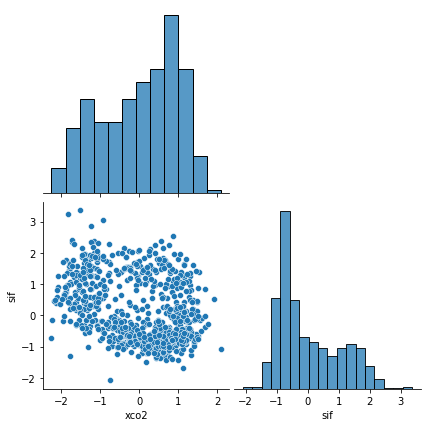

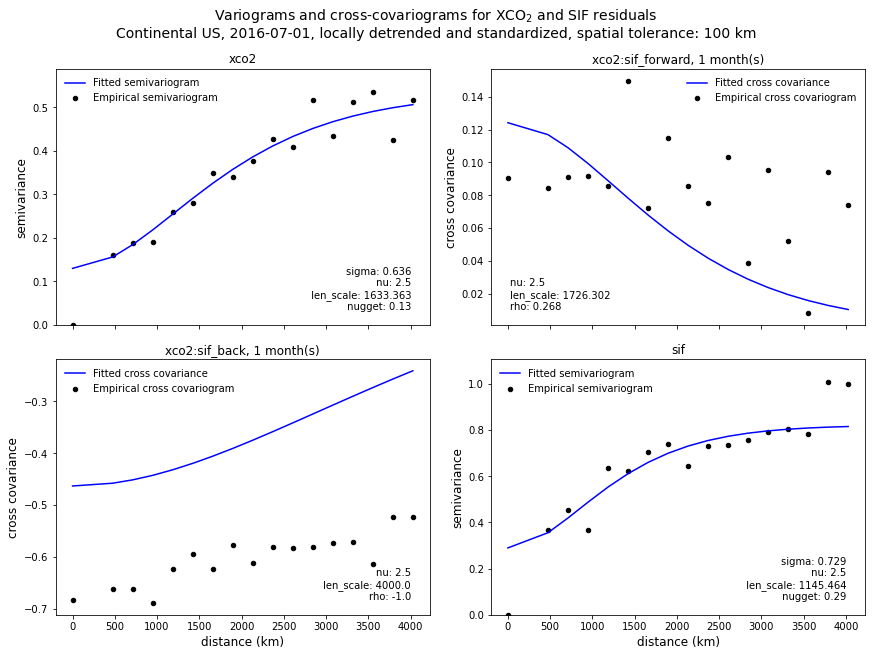

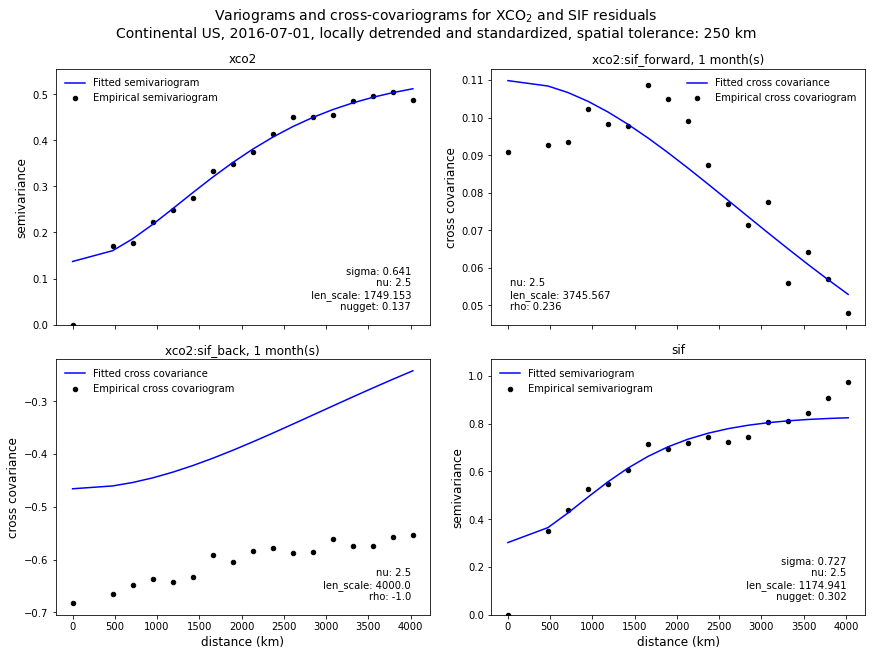

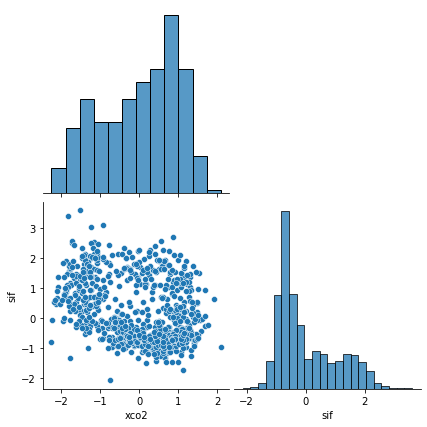

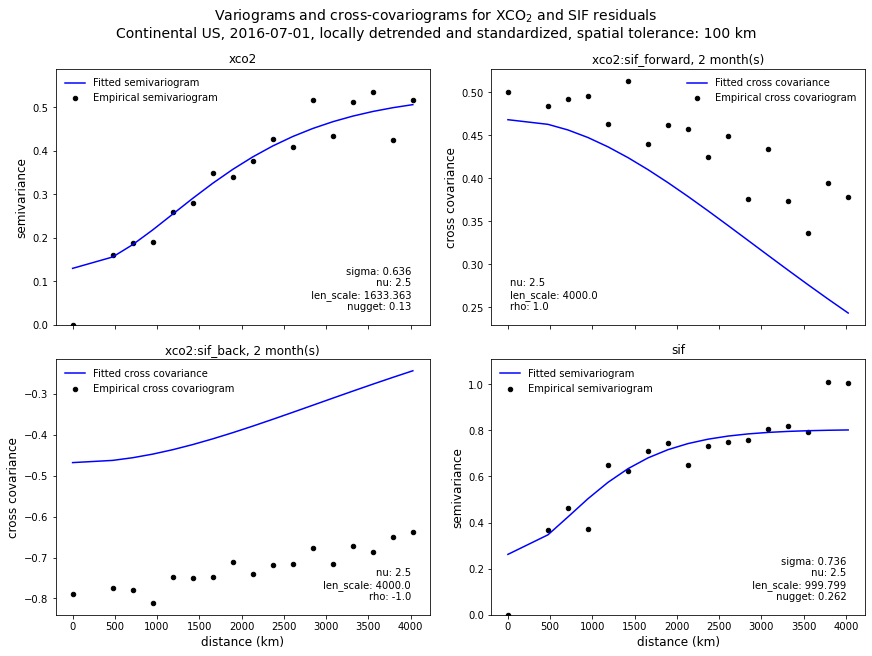

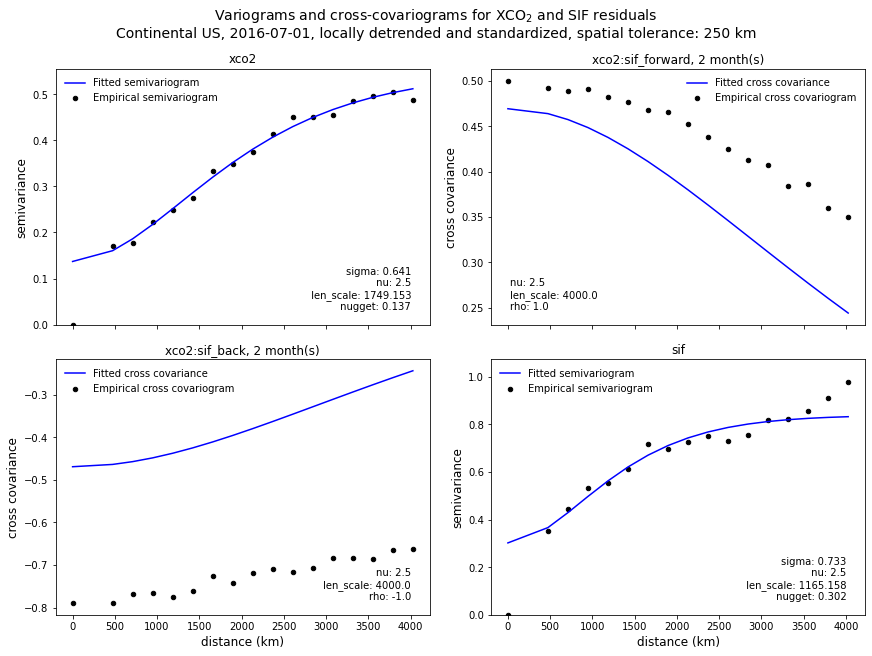

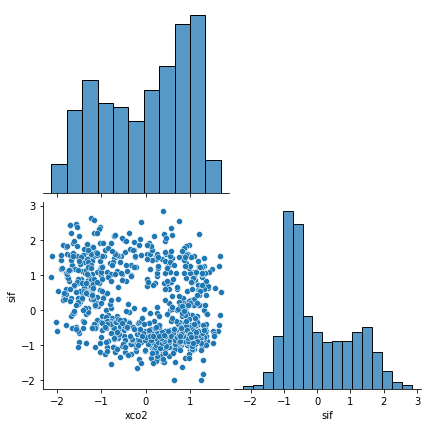

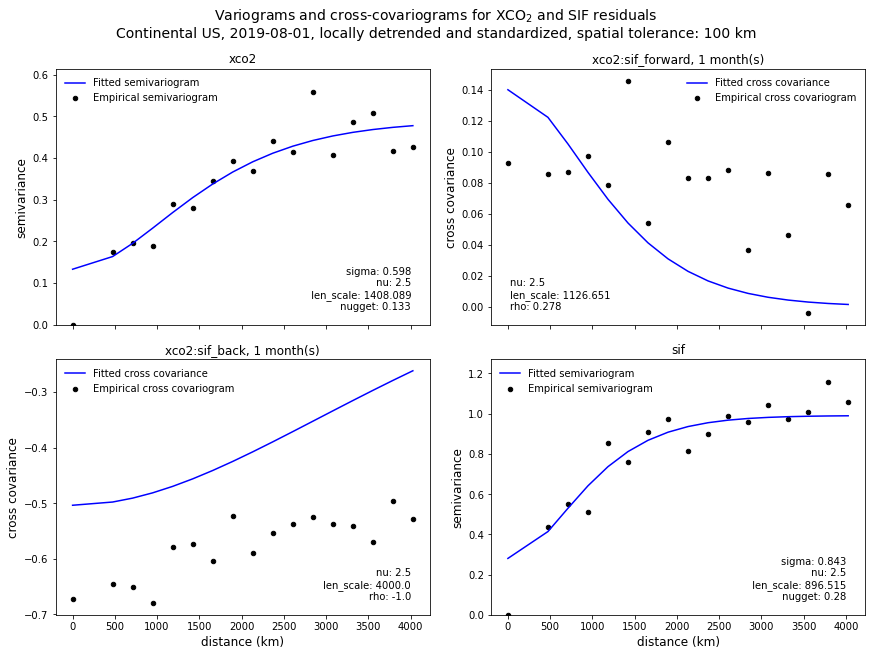

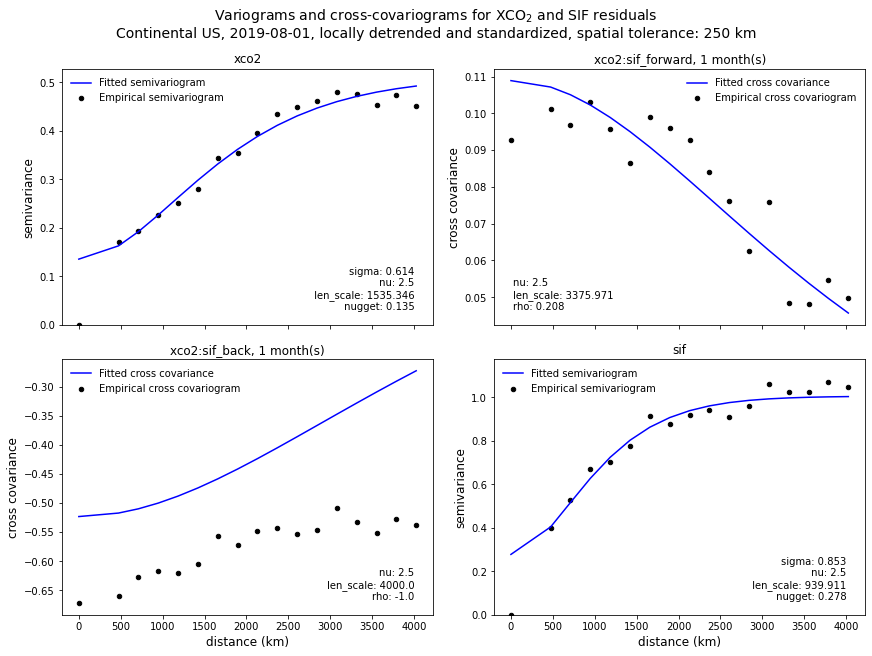

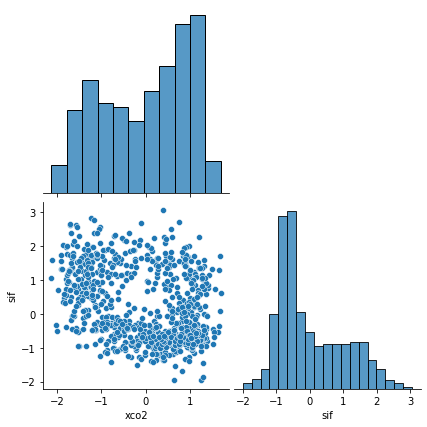

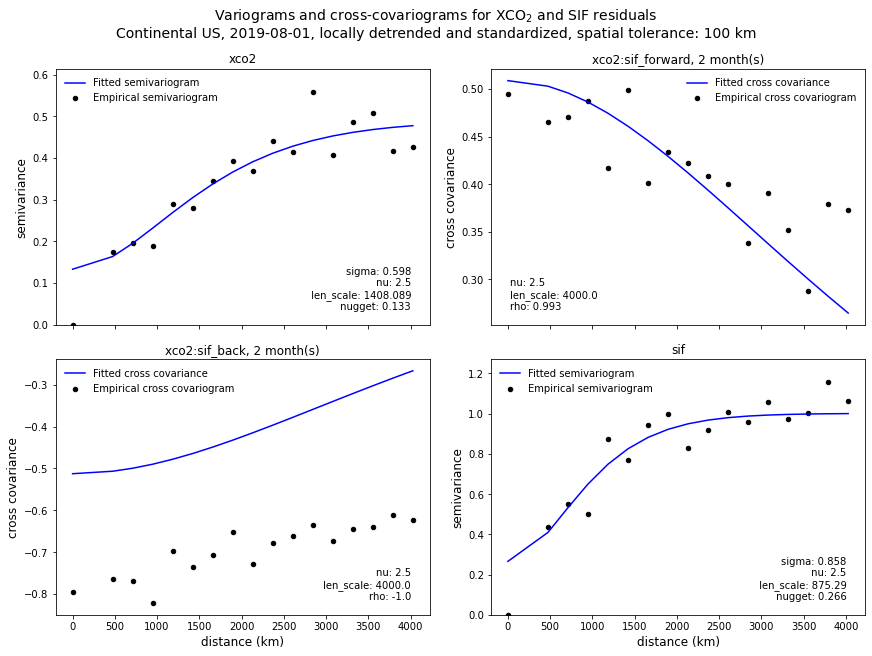

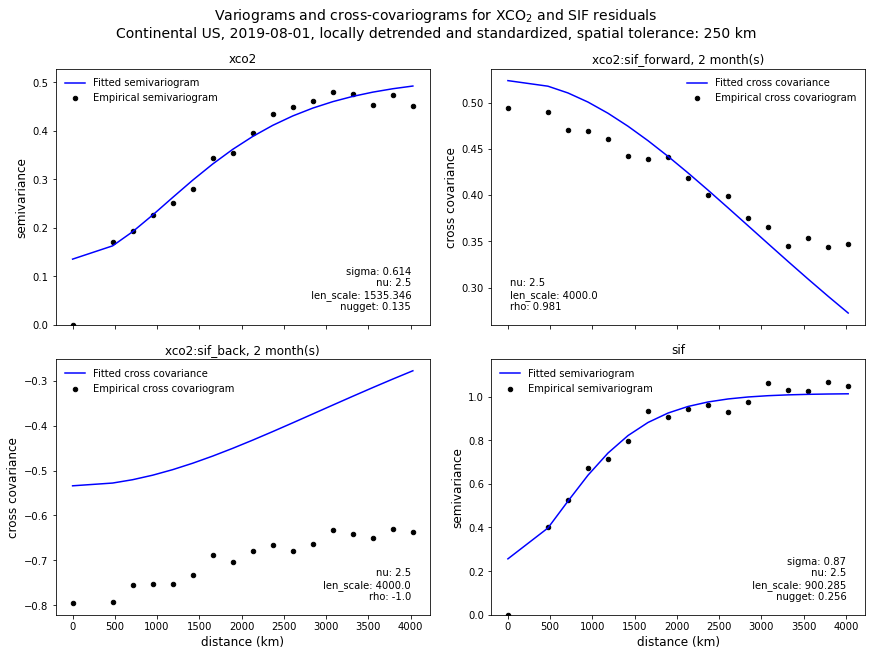

In [15]:
# Make all the plots
var_names = ["xco2", "sif"]
cross_names = ["xco2:sif_back", "xco2:sif_forward"]

for timestamp in timestamps:
    for timedelta in timedeltas:
        # Format as multi-field (detrending and standardizing)
        mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, standardize_window=True)
        
        # Check distributions
        df = pd.merge(mf.field_1.get_spacetime_df(), mf.field_2.get_spacetime_df(), how="outer", on=["lat", "lon", "time"])
        p = sns.pairplot(df, vars=var_names, corner=True, height=3)
        p.savefig(f"../plots/pairplot_{timestamp}.png")
        
        for tol in tols:
            print("New set")
            # Compute and fit empirical variograms and cross-covariogram
            vario_res, params_fit = vgm.variogram_analysis(
                mf,
                space_lags,
                tol,
                cov_guess,
                cross_guess
            )
            
            fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
            
            for i, var in enumerate(var_names):
                df = vario_res[var]
                df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical semivariogram")
                df.plot(x="lag", y="wls_fit", kind="line", color="blue", ax=ax[i, i], label="Fitted semivariogram")
                lim = df[var].max()
                ax[i, i].set_title(var, fontsize=12)
                ax[i, i].set_xlabel("distance (km)", fontsize=12)
                ax[i, i].set_ylabel("semivariance", fontsize=12)
                ax[i, i].set_ylim([0, lim+0.1*lim])
                ax[i, i].text(0.95, 0.05, param_labels(params_fit[var]), transform=ax[i, i].transAxes, ha="right", va="bottom")
                ax[i, i].legend(frameon=False)
                
            for i, cross in enumerate(cross_names):
                df = vario_res[cross]
                df.plot(x="lag", y="xco2:sif", kind="scatter", color="black", ax=ax[1-i, i], label="Empirical cross covariogram")
                df.plot(x="lag", y="wls_fit", kind="line", color="blue", ax=ax[1-i, i], label="Fitted cross covariance")
                ax[1-i, i].set_title(cross + f", {np.abs(timedelta)} month(s)", fontsize=12)
                ax[1-i, i].set_ylabel("cross covariance", fontsize=12)
                ax[1-i, i].set_xlabel("distance (km)", fontsize=12)
                if i == 0:
                    ax[1-i, i].text(0.95, 0.05, param_labels(params_fit[cross], cross=True), transform=ax[1-i, i].transAxes, ha="right", va="bottom")
                    ax[1-i, i].legend(loc="upper left", frameon=False)
                else:
                    ax[1-i, i].text(0.05, 0.05, param_labels(params_fit[cross], cross=True), transform=ax[1-i, i].transAxes, ha="left", va="bottom")
                    ax[1-i, i].legend(loc="upper right", frameon=False)

            fig.suptitle("Variograms and cross-covariograms for XCO$_2$ and SIF residuals\n"+
                         f"Continental US, {timestamp}, locally detrended and standardized, spatial tolerance: {tol} km", fontsize=14)

            fig.savefig(f"../plots/vario_analysis_conUS_{timestamp}_{np.abs(timedelta)}M_{tol}km.png", dpi=100);